**Install Libraries**

In [1]:
!pip install transformers datasets sacrebleu rouge_score py7zr -q

**Import Libraries**

In [3]:
from transformers import pipeline

import matplotlib.pyplot as plt

import pandas as pd
from datasets import load_dataset, load_metric

from transformers import T5ForConditionalGeneration, T5Tokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

# Download NLTK tokenizer data
nltk.download("punkt")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from datasets import load_dataset

**Initialize t5-base Model and Tokenizer**

In [5]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google-t5/t5-base"

tokenizer = T5Tokenizer.from_pretrained(model_ckpt)

model_t5 = T5ForConditionalGeneration.from_pretrained(model_ckpt).to(device)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

**Function to Calculate Rouge Metric on Test Dataset**

In [6]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements.
    
    Yields consecutive chunks from a list.

    Args:
        list_of_elements (List[Any]): The list to be divided into chunks.
        batch_size (int): The size of chunks.

    Yields:
        List[Any]: A chunk from the list of the specified size.
        
    """
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    """
    Calculates a specified metric on a test dataset.

    Args:
        dataset (Dataset): The dataset to evaluate.
        metric (Metric): The metric to calculate.
        model (nn.Module): The model to evaluate.
        tokenizer (Tokenizer): The tokenizer to use for text processing.
        batch_size (int, optional): The batch size for evaluation.
        device (torch.device, optional): The device to use for computation.
        column_text (str, optional): The name of the text column in the dataset.
        column_summary (str, optional): The name of the summary column in the dataset.

    Returns:
        Dict[str, float]: The calculated metric scores.
    """
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the <n> token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

**Loading the dataset**

In [7]:
dataset_dialogsum = load_dataset("knkarthick/dialogsum")
# Print split lengths and dataset features
split_lengths = [len(dataset_dialogsum[split])for split in dataset_dialogsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_dialogsum['train'].column_names}")

# Print an example dialogue and summary from the dataset
print("\nDialogue:")
print(dataset_dialogsum["test"][0]["dialogue"])

print("\nSummary:")
print(dataset_dialogsum["test"][0]["summary"])

Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Split lengths: [12460, 500, 1500]
Features: ['id', 'dialogue', 'summary', 'topic']

Dialogue:
#Person1#: Ms. Dawson, I need you to take a dictation for me.
#Person2#: Yes, sir...
#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?
#Person2#: Yes, sir. Go ahead.
#Person1#: Attention all staff... Effective immediately, all office communications are restricted to email correspondence and official memos. The use of Instant Message programs by employees during working hours is strictly prohibited.
#Person2#: Sir, does this apply to intra-office communications only? Or will it also restrict external communications?
#Person1#: It should apply to all communications, not only in this office between employees, but also any outside communications.
#Person2#: But sir, many employees use Instant Messaging to communicate with their clients.
#Person1#: They will just have to change their communication methods. I don't want any - one using Ins

**Initialize t5-base pipeline for Summarization**

In [8]:
pipe = pipeline('summarization', model = model_ckpt )

# Example of summarization using t5-base pipeline
pipe_out = pipe(dataset_dialogsum['test'][0]['dialogue'] )

print(pipe_out)

[{'summary_text': '#Person2#: This should go out as an intra-office memorandum to all employees by this afternoon . effective immediately, all office communications are restricted to email correspondence and official memos . the use of Instant Message programs by employees during working hours is strictly prohibited .'}]


In [9]:
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

#Person2#: This should go out as an intra-office memorandum to all employees by this afternoon . effective immediately, all office communications are restricted to email correspondence and official memos . the use of Instant Message programs by employees during working hours is strictly prohibited .


**Initialize ROUGE metric for evaluation**

In [10]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_dialogsum['test'], rouge_metric, model_t5, tokenizer, column_text = 'dialogue', column_summary='summary', batch_size=8 )

/tmp/ipykernel_34/4022923359.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


100%|██████████| 188/188 [31:03<00:00,  9.91s/it]


In [11]:
# Print ROUGE scores
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['t5-base'])

,rouge1,rouge2,rougeL,rougeLsum
t5-base,0.215195,0.050517,0.160379,0.160264


**Histogram**

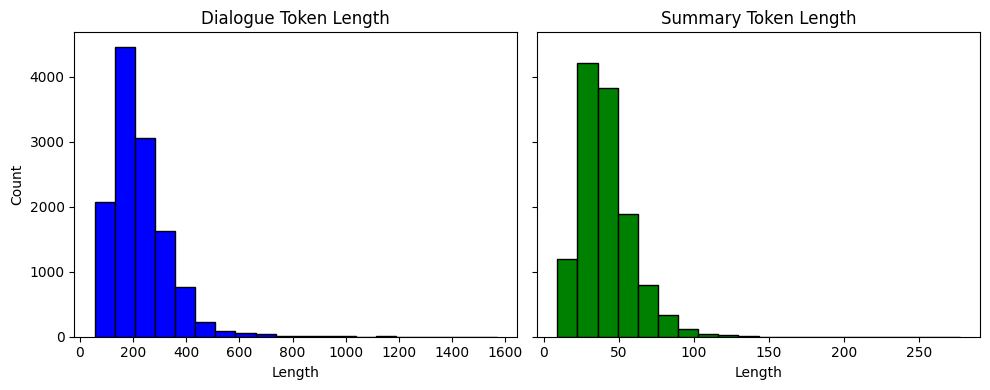

In [12]:
dialogue_token_len = [len(tokenizer.encode(s)) for s in dataset_dialogsum['train']['dialogue']]

summary_token_len = [len(tokenizer.encode(s)) for s in dataset_dialogsum['train']['summary']]


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].hist(dialogue_token_len, bins = 20, color = 'blue', edgecolor = 'black' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'green', edgecolor = 'black' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")

plt.tight_layout()
plt.show()

**Function to convert dataset examples to features for Seq2Seq model**

In [13]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
# Map dataset examples to features for Seq2Seq model training
dataset_dialogsum_pt = dataset_dialogsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [15]:
from transformers import DataCollatorForSeq2Seq
#Data collator for Seq2Seq training
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_t5)

**Training**

In [16]:
# Training arguments for Trainer
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='/kaggle/working/t5-dialogsum', num_train_epochs=2, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
) 

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
# Trainer for Seq2Seq model training
trainer = Trainer(model=model_t5, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_dialogsum_pt["train"], 
                  eval_dataset=dataset_dialogsum_pt["validation"])

In [18]:
# Train Seq2Seq model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
500,1.163000,1.114005
1000,1.123300,1.044228
1500,1.122500,1.029261


TrainOutput(global_step=1556, training_loss=1.2462841014935608, metrics={'train_runtime': 2836.885, 'train_samples_per_second': 8.784, 'train_steps_per_second': 0.548, 'total_flos': 6640893936460800.0, 'train_loss': 1.2462841014935608, 'epoch': 1.9980738362760835})

In [19]:
# Calculate ROUGE scores on test dataset using trained Seq2Seq model
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

rouge_metric = load_metric('rouge')

/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [20]:
# Print ROUGE scores
score = calculate_metric_on_test_ds(
    dataset_dialogsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f't5-base'] )

100%|██████████| 750/750 [22:23<00:00,  1.79s/it]


,rouge1,rouge2,rougeL,rougeLsum
t5-base,0.411054,0.158213,0.335262,0.334958


In [21]:
# Save Model
model_t5.save_pretrained("/kaggle/working/t5-dialogsum-model")

In [22]:
# Save tokenizer
tokenizer.save_pretrained("/kaggle/working/tokenizer")

('/kaggle/working/tokenizer/tokenizer_config.json',
 '/kaggle/working/tokenizer/special_tokens_map.json',
 '/kaggle/working/tokenizer/spiece.model',
 '/kaggle/working/tokenizer/added_tokens.json')

In [26]:
# Load
tokenizer = T5Tokenizer.from_pretrained("/kaggle/working/tokenizer")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


**Generating Summaries**

In [27]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

sample_text = dataset_dialogsum["test"][0]["dialogue"]

reference = dataset_dialogsum["test"][0]["summary"]

pipe = pipeline("summarization", model="/kaggle/working/t5-dialogsum-model",tokenizer=tokenizer)

print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
#Person1#: Ms. Dawson, I need you to take a dictation for me.
#Person2#: Yes, sir...
#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?
#Person2#: Yes, sir. Go ahead.
#Person1#: Attention all staff... Effective immediately, all office communications are restricted to email correspondence and official memos. The use of Instant Message programs by employees during working hours is strictly prohibited.
#Person2#: Sir, does this apply to intra-office communications only? Or will it also restrict external communications?
#Person1#: It should apply to all communications, not only in this office between employees, but also any outside communications.
#Person2#: But sir, many employees use Instant Messaging to communicate with their clients.
#Person1#: They will just have to change their communication methods. I don't want any - one using Instant Messaging in this office. It wastes too much time! Now, please continue with th